In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import os
import shutil
from torchvision import datasets
from torchvision.io import read_image
import pandas as pd
import matplotlib.pyplot as plt
import math
import PIL
import seaborn as sns

c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Pre-condition we need to have the following files in the same directory:
- top4_materials.csv 
- /top4_materials_non_plural/

In [2]:
source = "./top4_materials_non_plural/"
target = "./data_split/"

if (not os.path.exists(target)):
    os.mkdir(target)

In [3]:
possible_classes =[]
for files in os.listdir(source):
    possible_classes.append(int(files))

In [4]:
#shuffle possible_classes into 80% train, 10% val, 10% test
def shuffle_split(possible_classes):
    #shuffle ints
    np.random.shuffle(possible_classes)
    #split into 80% train, 10% val, 10% test
    train = possible_classes[:int(len(possible_classes)*0.8)]
    val = possible_classes[int(len(possible_classes)*0.8):int(len(possible_classes)*0.9)]
    test = possible_classes[int(len(possible_classes)*0.9):]
    return train, val, test


In [5]:
train, val, test = shuffle_split(possible_classes=possible_classes)

In [6]:
#delete old data_split folder
if (os.path.exists(target)):
    shutil.rmtree(target)
    os.mkdir(target)

In [7]:
#copy files into train/val/test based on split
if (not os.path.exists(target + "train") and not os.path.exists(target + "val") and not os.path.exists(target + "test")):
    os.mkdir(target + "train")
    os.mkdir(target + "val")
    os.mkdir(target + "test")
    for file in os.listdir(source):
        if (int(file) in train):
            for files in os.listdir(source + file):
                shutil.copy(source + file + "/" + files, target + "train/" + files)
        elif (int(file) in val):
            for files in os.listdir(source + file):
                shutil.copy(source + file + "/" + files, target + "val/" + files)
        elif (int(file) in test):
            for files in os.listdir(source + file):
                shutil.copy(source + file + "/" + files, target + "test/" + files)

In [8]:
#custom dataset class
class Top4Dataset(Dataset):
    def __init__(self, csv_file, root_dir, label, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(csv_file)
        self.transform = transform
        self.image_names = os.listdir(root_dir)
        self.label = label
    def __len__(self):
        return len(self.image_names)
    
    def __items_class__(self):
        return self.label
    def __getitem__(self, index):
        img_name = self.image_names[index]
        img_path = os.path.join(self.root_dir, img_name)
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        image = image.float()
        material_name = self.annotations.iloc[index, 1]
        y_label = torch.tensor(self.label[material_name])
        return (image, y_label)

In [9]:
material_label = {"plastic": 0, "metal": 1,"paper": 2, "wood": 3, "other": 4}

In [10]:
#data transforms
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((144,144)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomApply([transforms.RandomRotation(180), transforms.ColorJitter(brightness=.5, hue=.3)], p=0.5),
    transforms.ToTensor(),
])

In [11]:
Top4Dataset_Train = Top4Dataset(csv_file = "./top4_materials.csv", root_dir = "./data_split/train", label= material_label, transform=data_transforms)
Top4Dataset_Val = Top4Dataset(csv_file = "./top4_materials.csv", root_dir = "./data_split/val", label= material_label, transform=data_transforms)
Top4Dataset_Test = Top4Dataset(csv_file = "./top4_materials.csv", root_dir = "./data_split/test", label= material_label, transform=data_transforms)


In [12]:
DataLoader_Train = DataLoader(dataset = Top4Dataset_Train, batch_size = 32, shuffle = True)
DataLoader_Val = DataLoader(dataset = Top4Dataset_Val, batch_size = 32, shuffle = True)
DataLoader_Test = DataLoader(dataset = Top4Dataset_Test, batch_size = 32, shuffle = True)

print(f"length of train dataset: {len(Top4Dataset_Train)}")
print(f"length of val dataset: {len(Top4Dataset_Val)}")
print(f"length of test dataset: {len(Top4Dataset_Test)}")

length of train dataset: 7296
length of val dataset: 912
length of test dataset: 912


In [13]:
for images, labels in DataLoader_Train:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 144, 144])
torch.Size([32])


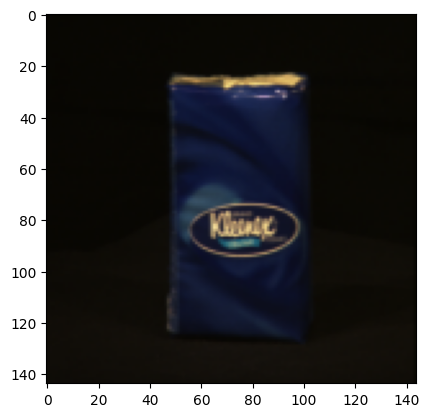

In [14]:
#show images under transformations

img_path = "./data_split/train/100_i110.png"
image = read_image(img_path)
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((144,144)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomApply([transforms.RandomRotation(180), transforms.ColorJitter(brightness=.5, hue=.3)], p=0.5),
    transforms.ToTensor(),
])

image = data_transforms(image)
image = image.float()
plt.imshow(image.permute(1,2,0))


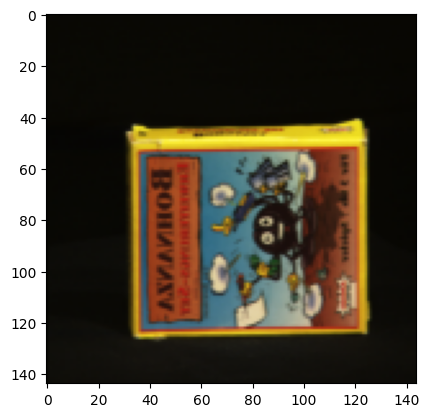

In [15]:
#show images
img = next(iter(DataLoader_Train))[0][0]
plt.imshow(img.permute(1,2,0))

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(3, 20, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=3, stride=3),
            nn.Conv2d(20, 50, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=3, stride=3),
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(12800, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 5),
            nn.ReLU(),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        logits = self.conv_relu_stack(x)
        logits = self.flatten(logits)
        logits = self.linear_relu_stack(logits)
        return logits

model = ConvNeuralNetwork().to(device)
print(model)

Using cuda device
ConvNeuralNetwork(
  (conv_relu_stack): Sequential(
    (0): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=3, stride=3, padding=0)
    (3): Conv2d(20, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=3, stride=3, padding=0)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12800, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=5, bias=True)
    (6): ReLU()
    (7): LogSoftmax(dim=1)
  )
)


In [17]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    loss_result = 0
    for batch, (X, y) in enumerate(dataloader):
        # add noise to the image
        # Compute prediction error
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_result += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_result/len(dataloader)

In [18]:
class EarlyStopper():
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss >= (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [19]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [20]:
#model parameters
learning_rate = 1e-3
epochs = 100
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
#train model
early_stopping = EarlyStopper()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(DataLoader_Train, model, loss_fn, optimizer)
    test_loss = test(DataLoader_Test, model, loss_fn)
    if early_stopping.early_stop(test_loss):
        print("Early stopping")
        break
print("Done!")

Epoch 1
-------------------------------
loss: 1.605632  [    0/ 7296]
loss: 1.412697  [ 3200/ 7296]
loss: 1.213621  [ 6400/ 7296]
Test Error: 
 Accuracy: 33.9%, Avg loss: 1.476761 

Epoch 2
-------------------------------
loss: 1.437930  [    0/ 7296]
loss: 1.445187  [ 3200/ 7296]
loss: 1.282842  [ 6400/ 7296]
Test Error: 
 Accuracy: 35.9%, Avg loss: 1.453568 

Epoch 3
-------------------------------
loss: 1.188726  [    0/ 7296]
loss: 1.092011  [ 3200/ 7296]
loss: 1.379473  [ 6400/ 7296]
Test Error: 
 Accuracy: 37.4%, Avg loss: 1.496061 

Early stopping
Done!


In [22]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    xb = transforms.Resize((144,144))(xb)
    xb = xb.to(device)
    xb = xb.float()
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

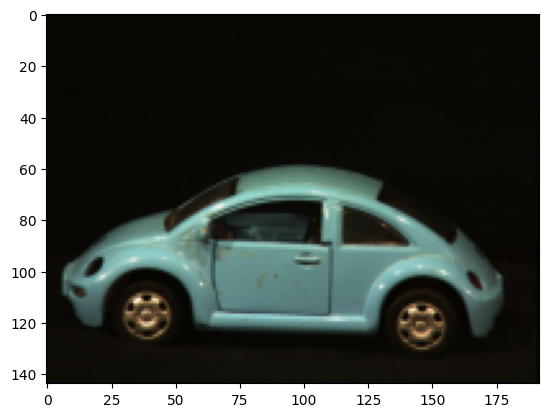

In [24]:
#note the shuffle is random so you need to check which image is set to val
test_image_path = "./data_split/val/138_i110.png"
img_name = test_image_path.split("/")[-1]
test_image = read_image(test_image_path)

shower = plt.imread(test_image_path)
plt.imshow(shower)


In [25]:

# function to return key for any value
def get_key(val, my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key
 
    return "key doesn't exist"

In [26]:
result = predict_image(test_image, model)
result_label = get_key(result, material_label)

actual_label_table = pd.read_csv("./top4_materials.csv")
actual_label = actual_label_table[actual_label_table["name_img"] == img_name]["material"].values[0]
print(f"Predicted class: {result_label,result}")
print(f"Actual class: {actual_label}")


Predicted class: ('plastic', 0)
Actual class: plastic


In [27]:
def confusionMatrix(model, dataloader):
    confusion_matrix = torch.zeros(5, 5)
    with torch.no_grad():
        total = 0
        for i, (inputs, classes) in enumerate(dataloader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    return confusion_matrix

In [28]:
confusion_matrix = confusionMatrix(model, DataLoader_Test)

In [29]:
confusion_matrix

tensor([[247.,   0.,   0.,   0., 185.],
        [ 24.,   0.,   0.,   0.,   0.],
        [ 51.,   0.,   0.,   0.,   9.],
        [108.,   0.,   0.,   0.,  72.],
        [121.,   0.,   0.,   0.,  95.]])

In [30]:
material_label

{'plastic': 0, 'metal': 1, 'paper': 2, 'wood': 3, 'other': 4}

Text(0.5, 1.0, 'Confusion matrix')

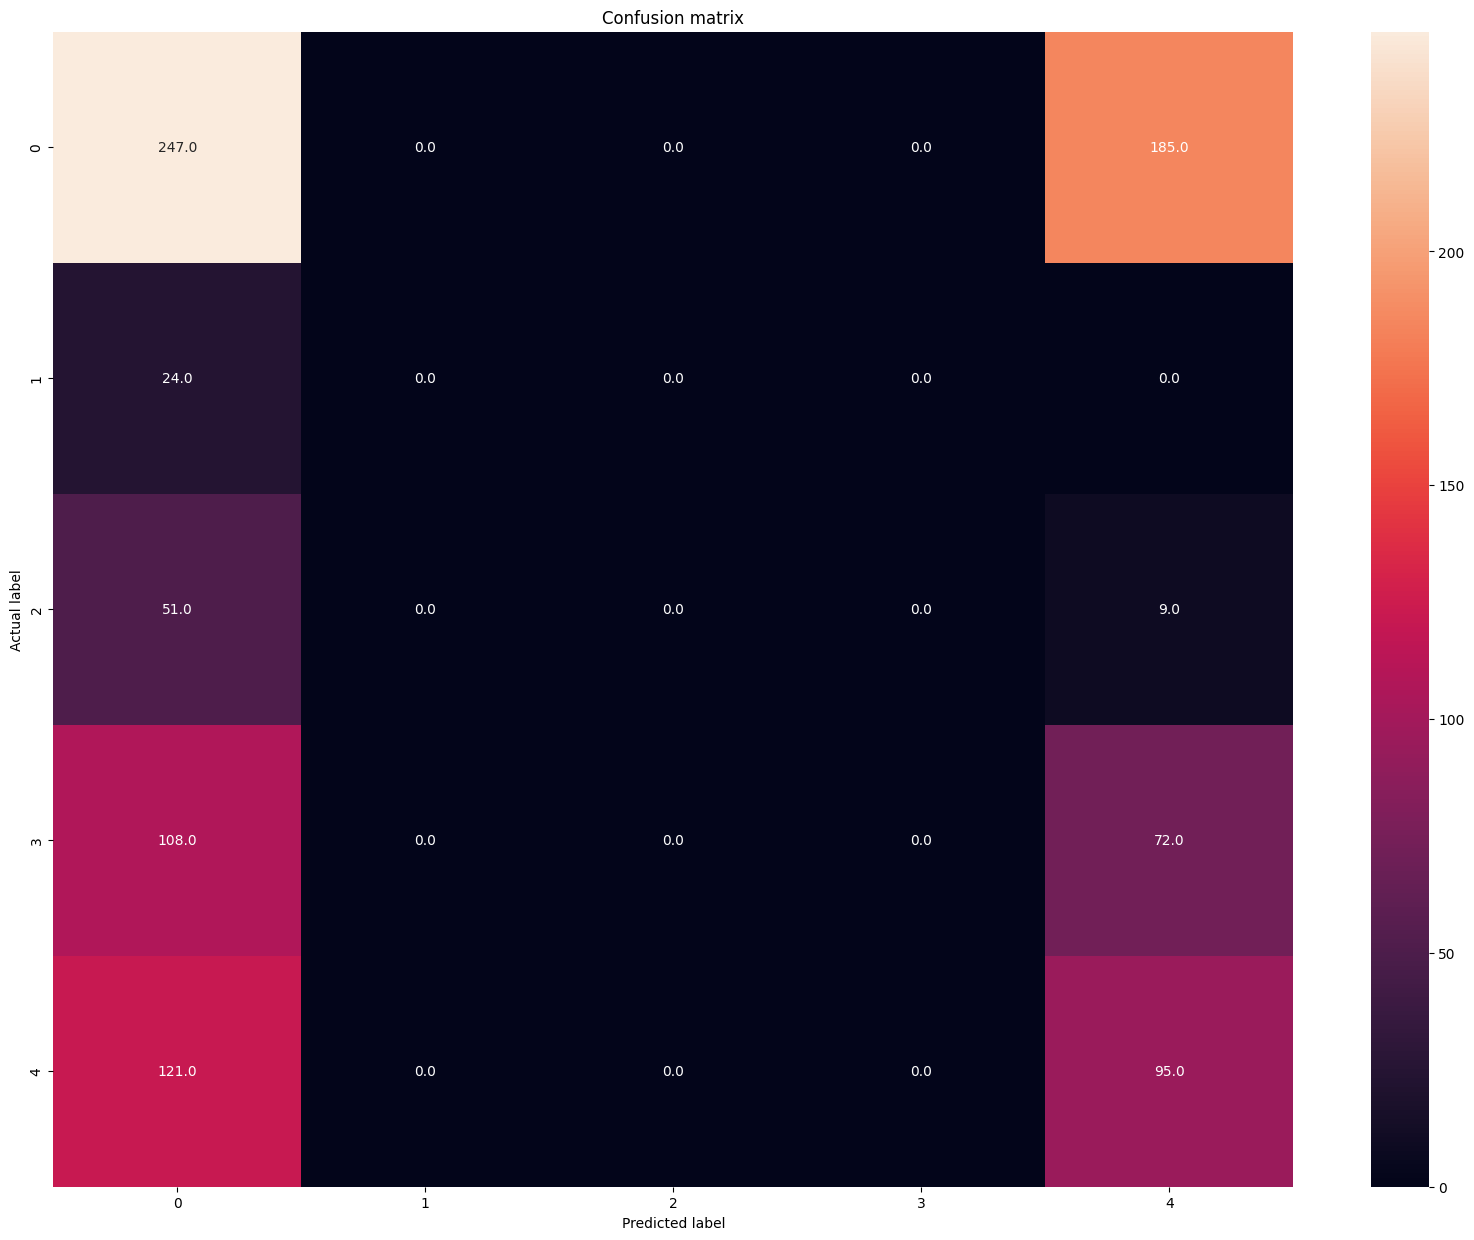

In [33]:
# Plot confusion matrix
plt.figure(figsize=(20,15))
sns.heatmap(confusion_matrix, annot=True, fmt=".1f")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title("Confusion matrix")

In [32]:
random = torch.randn(3,144, 192)
conv1 = nn.Conv2d(3, 20, kernel_size=5, padding=1)
pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
conv2 = nn.Conv2d(20, 50, kernel_size=3, padding=1)
pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

out = conv1(random)
out = pool1(out)
out = conv2(out)
out = pool2(out)
out.shape

torch.Size([50, 35, 47])